In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io.wavfile as wav

from collections import namedtuple
from scipy.signal import find_peaks
from scipy.fft import fft


# decompose a signal into non overlapping frames
def non_overlapping_frames(signal, fs, frame_duration):
    frame_len = round(frame_duration * fs)
    total_frames = len(signal) // frame_len

    frames = signal[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


# decompose a signal into overlapping frames
def overlapping_frames(signal, fs, frame_duration, overlap):
    frame_len = round(frame_duration * fs)
    hop_len = round(frame_len * (1 - overlap))
    total_frames = 1 + (len(signal) - frame_len) // hop_len

    frames = np.zeros((frame_len, total_frames))
    for i in range(total_frames):
        start = i * hop_len
        end = start + frame_len
        frames[:, i] = signal[start:end]

    return frames


# plot a signal in continuous time
def plot_continuous(signal, fs, title, ylabel=None):
    t = np.arange(len(signal)) / fs

    plt.plot(t, signal)
    plt.xlabel("Time (s)")

    if title:
        plt.title(title)

    if ylabel:
        plt.ylabel(ylabel)

    plt.show()


# plot a signal in both continuous and discrete time in the same plot
def plot_continuous_discrete(signal, fs, title):
    Ly = len(signal)
    t = np.arange(Ly) / fs
    n = np.arange(Ly)

    fig, ax = plt.subplots(2, layout="constrained")

    ax[0].plot(t, signal)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Continuous")

    ax[1].plot(n, signal)
    ax[1].set_xlabel("n")
    ax[1].set_title("Discrete")

    if title:
        fig.suptitle(title)

    plt.show()


# calculate the fundamental frequency of a signal using fft
def calculate_fundamental_frequency(signal, fs):
    # calculate the fft of the signal
    spectrum = fft(signal)

    # calculate the magnitude of the spectrum
    magnitude = np.abs(spectrum)

    # find the peaks
    peaks, _ = find_peaks(magnitude)

    # calculate the frequencies of the peaks
    frequencies = np.arange(len(magnitude)) * fs / len(magnitude)

    # find the peak with the highest frequency
    max_peak = peaks[np.argmax(magnitude[peaks])]

    return frequencies[max_peak]

## Ejercicio 1.1

Escuchamos las señales y las representamos tiempo continuo y discreto.


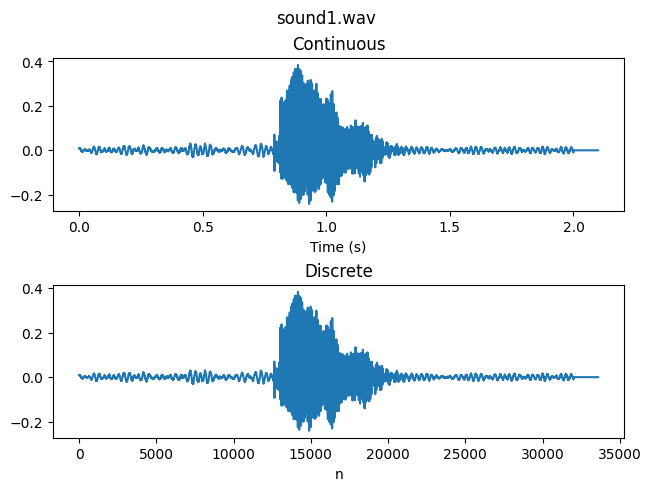

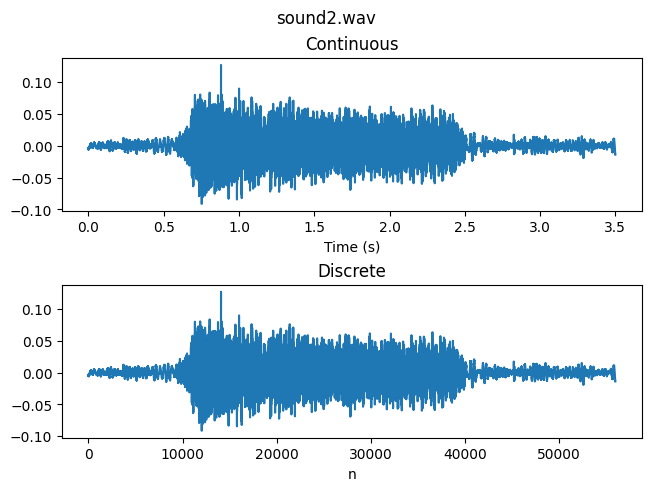

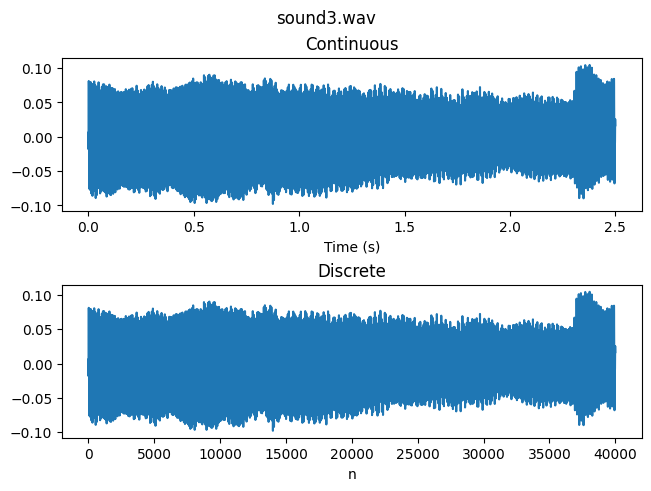

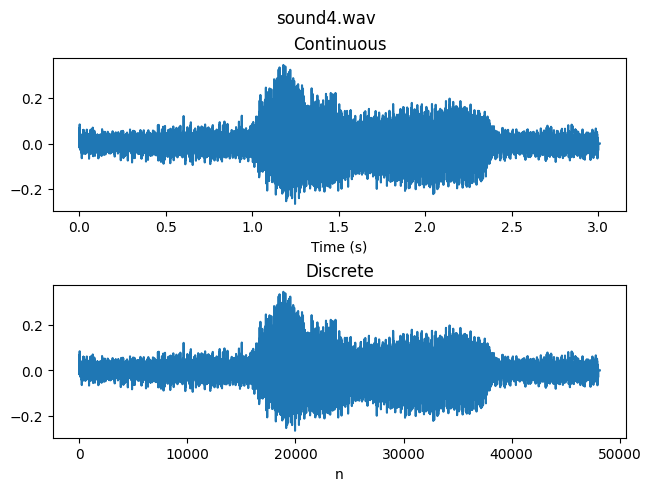

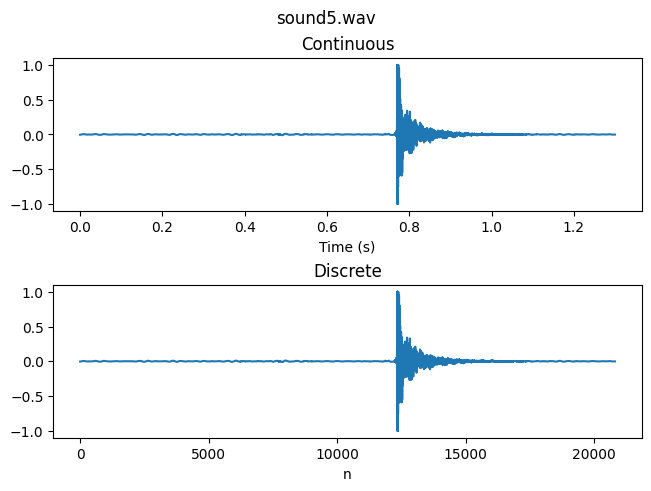

In [2]:
AUDIO_DIR = "../audio"

# set numpy print options to print only 10 elements of an array
np.set_printoptions(threshold=10)

# Create a named tuple to represent a signal
Signal = namedtuple("Signal", ["y", "fs", "file"])

# Read all the .wav files in the audio directory
signals = []
for file in sorted(os.listdir(AUDIO_DIR)):
    if file.endswith(".wav") and file != "mi_sonido.wav":
        # get the signal and the sampling frequency
        fs, y = wav.read(os.path.join(AUDIO_DIR, file))

        # normalize the signal
        # signals are stored as 16-bit signed integers
        y = y / 2**15

        # create a Signal object and append it to the list
        signals.append(Signal(y, fs, file))

# Plot and play the signals
for signal in signals:
    plot_continuous_discrete(signal.y, signal.fs, signal.file)

    # Play the audio
    # import sounddevice as sd

    # sd.play(signal.y, signal.fs)
    # sd.wait()

## Ejercicio 1.2

Representamos un tramo de 100ms de cada señal en tiempo continuo y calculamos la potencia media, la energía y el periodo fundamental de las señales que sean periodicas.


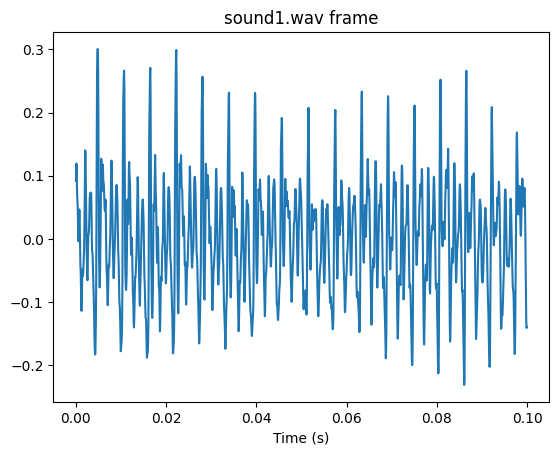

Fundamental frecuecny of signal sound1.wav: 680.0 hz
Fundamental period of signal sound1.wav: 0.0014705882352941176 s
Power of signal sound1.wav: 0.0013667823540024636 W
Energy of signal sound1.wav: 45.92388709448278 J


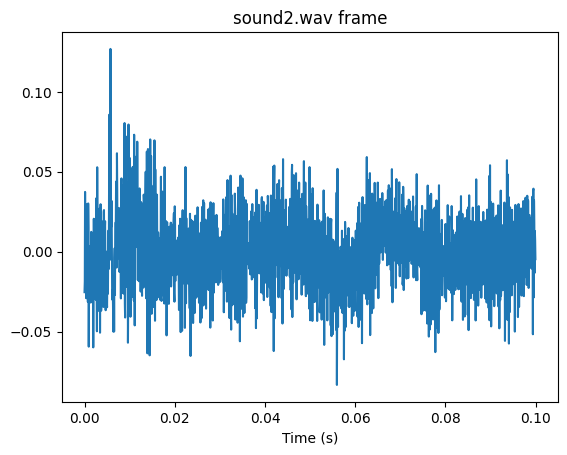

Fundamental frecuecny of signal sound2.wav: 30.0 hz
Fundamental period of signal sound2.wav: 0.03333333333333333 s
Power of signal sound2.wav: 0.00023101726882985245 W
Energy of signal sound2.wav: 12.937198071740568 J


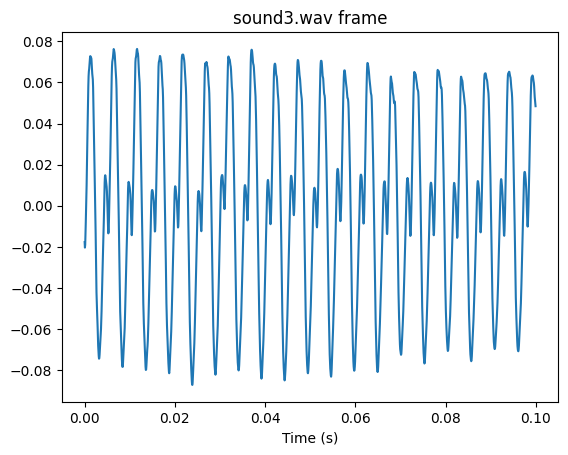

Fundamental frecuecny of signal sound3.wav: 190.0 hz
Fundamental period of signal sound3.wav: 0.005263157894736842 s
Power of signal sound3.wav: 0.0017629009635537832 W
Energy of signal sound3.wav: 70.51780144311488 J


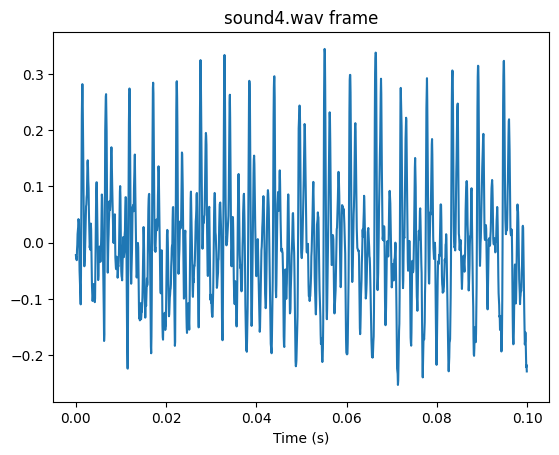

Fundamental frecuecny of signal sound4.wav: 710.0 hz
Fundamental period of signal sound4.wav: 0.0014084507042253522 s
Power of signal sound4.wav: 0.003618658825958556 W
Energy of signal sound4.wav: 174.27460905816406 J


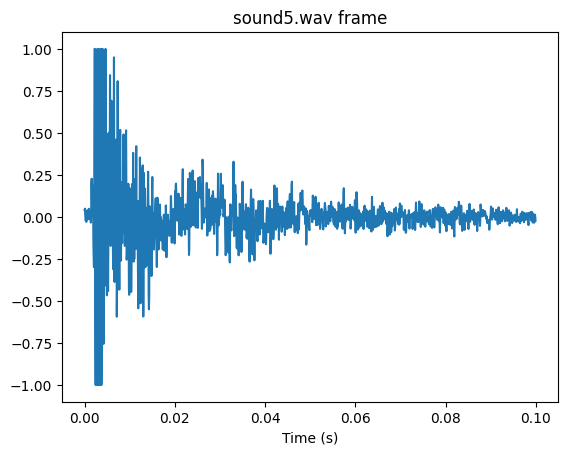

Fundamental frecuecny of signal sound5.wav: 50.0 hz
Fundamental period of signal sound5.wav: 0.02 s
Power of signal sound5.wav: 0.00247044702086086 W
Energy of signal sound5.wav: 51.38776848092675 J


In [3]:
# values chosen by hand to get the relevant part of the signals
frames_start = {
    "sound1.wav": 15000,
    "sound2.wav": 14000,
    "sound3.wav": 1000,
    "sound4.wav": 18000,
    "sound5.wav": 12300,
}

frame_duration = 0.1  # frame duration in seconds

for signal in signals:
    # calculate the length of the frames
    yframe_len = round(frame_duration * signal.fs)

    # extract the frame from the original signal.
    yframe = signal.y[
        frames_start[signal.file] : frames_start[signal.file] + yframe_len
    ]

    # plot the frames
    plot_continuous(yframe, signal.fs, f"{signal.file} frame")

    # calculate the fundamental frequency of the signal
    fundamental_frequency = calculate_fundamental_frequency(yframe, signal.fs)
    print(f"Fundamental frecuecny of signal {signal.file}: {fundamental_frequency} hz")
    print(f"Fundamental period of signal {signal.file}: {1 / fundamental_frequency} s")

    # calculate the power and energy of the signal
    print(f"Power of signal {signal.file}: {(signal.y ** 2).mean()} W")
    print(f"Energy of signal {signal.file}: {(signal.y ** 2).sum()} J")

## Ejercicio 1.3

Calculamos la energía de las señales en tramas de 100ms sin solape y las representamos.


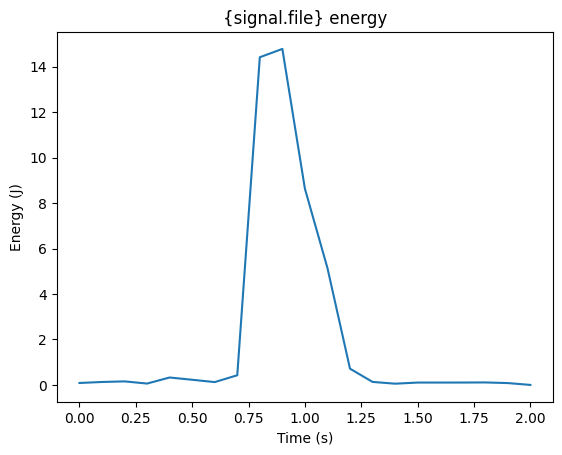

Energy of signal sound1.wav (non overlapping frames): [8.55939379e-02 1.29535472e-01 1.55837758e-01 ... 1.09188259e-01
 8.16809731e-02 9.29981470e-05] J


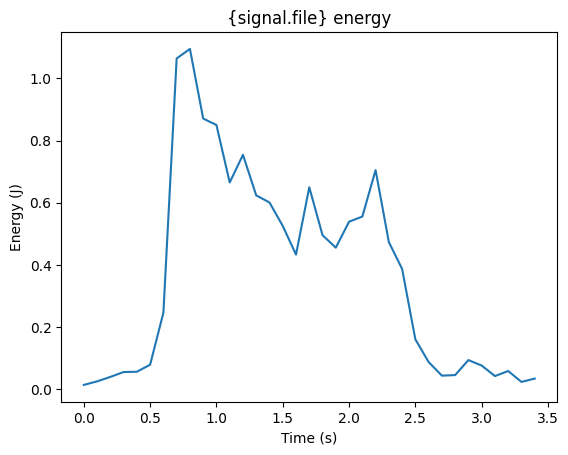

Energy of signal sound2.wav (non overlapping frames): [0.01466785 0.02605151 0.04042561 ... 0.05937697 0.0242974  0.03503857] J


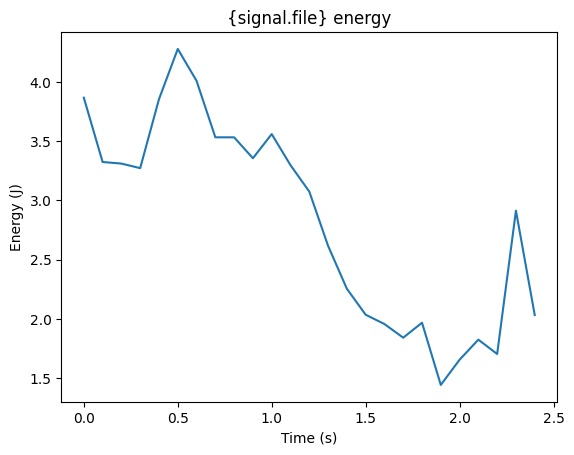

Energy of signal sound3.wav (non overlapping frames): [3.8680609  3.32501603 3.31144512 ... 1.70272768 2.91374796 2.03156425] J


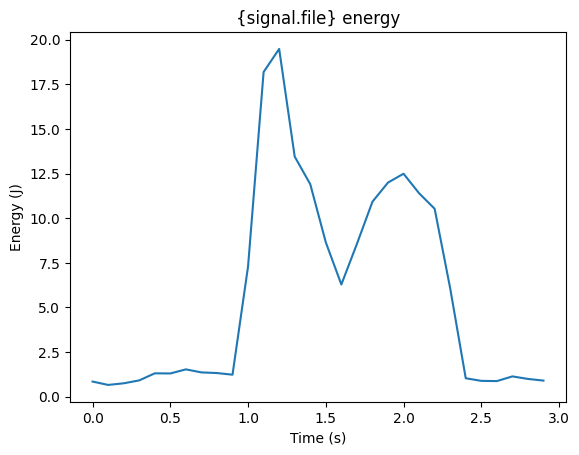

Energy of signal sound4.wav (non overlapping frames): [0.84988339 0.66106911 0.751822   ... 1.13838931 0.9967622  0.90332989] J


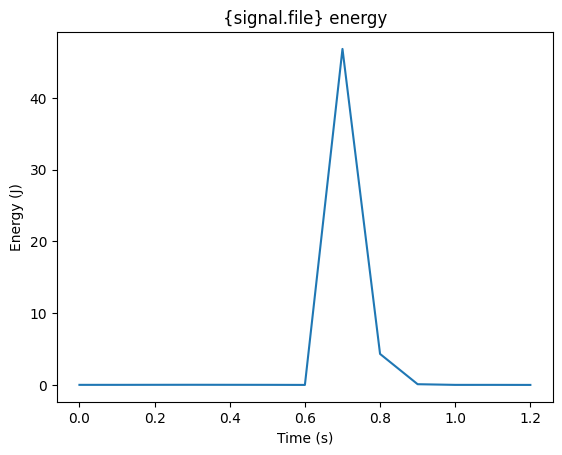

Energy of signal sound5.wav (non overlapping frames): [0.01364367 0.01474999 0.020434   ... 0.01124525 0.01211548 0.00475643] J


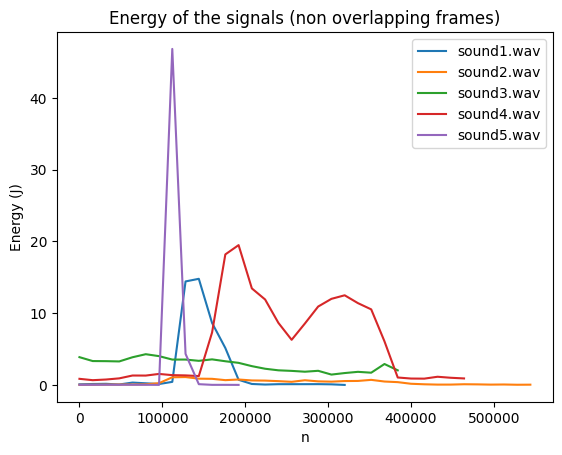

In [4]:
E_frames = []

frame_duration = 0.1  # frame duration in seconds
fs = 1 / frame_duration

for signal in signals:
    # get the energy of the signal in overlapping frames of 100ms
    E_frame = (non_overlapping_frames(signal.y, signal.fs, frame_duration) ** 2).sum(
        axis=0
    )
    E_frames.append(E_frame)

    # plot the energy of the signal in continuous time
    plot_continuous(E_frame, fs, "{signal.file} energy", ylabel="Energy (J)")
    print(f"Energy of signal {signal.file} (non overlapping frames): {E_frame} J")

for E_frame in E_frames:
    # add the energy of the signal to the final plot with the energy of all the signals
    t = np.arange(len(E_frame)) * signal.fs
    plt.plot(t, E_frame)

# plot the energy of all the signals in discrete time
plt.xlabel("n")
plt.ylabel("Energy (J)")
plt.title("Energy of the signals (non overlapping frames)")
plt.legend([signal.file for signal in signals])
plt.show()

## Ejercicio 1.4

Calculamos la energía de las señales en tramas de 20ms con solape y las representamos.


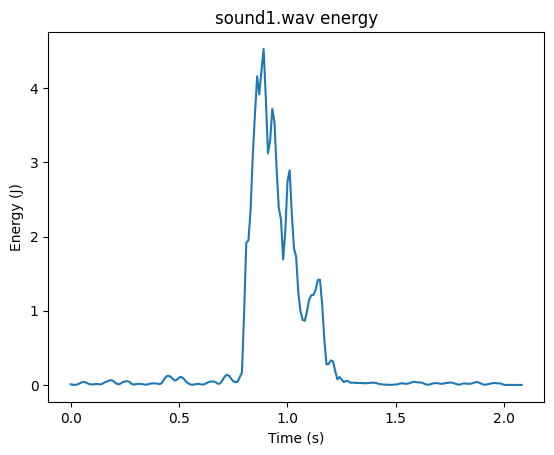

Energy of signal sound1.wav (overlapping frames 50.0%): [0.00799743 0.00272038 0.00074857 ... 0.         0.         0.        ] J


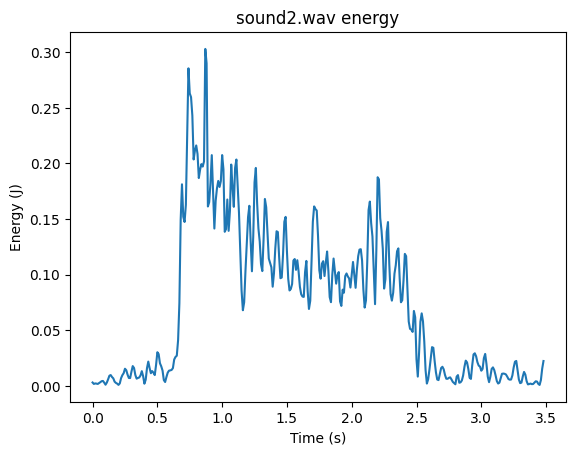

Energy of signal sound2.wav (overlapping frames 50.0%): [0.00302145 0.00172455 0.00220205 ... 0.00516222 0.01542371 0.02234163] J


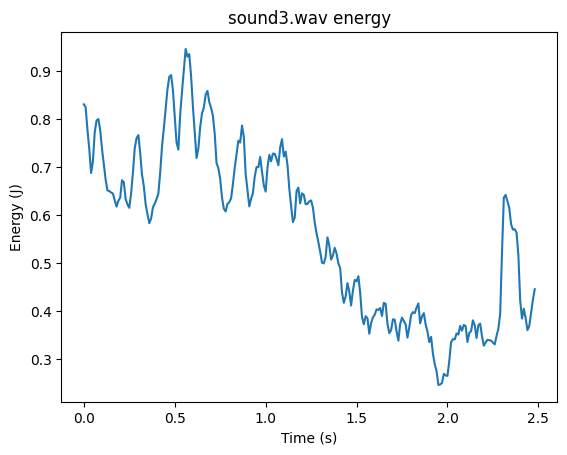

Energy of signal sound3.wav (overlapping frames 50.0%): [0.83060121 0.82435782 0.77724672 ... 0.39700086 0.42399068 0.44600228] J


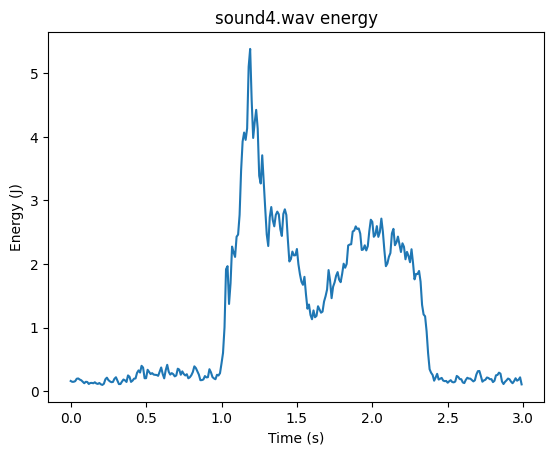

Energy of signal sound4.wav (overlapping frames 50.0%): [0.16362986 0.15033018 0.1509197  ... 0.18376608 0.22046842 0.11012721] J


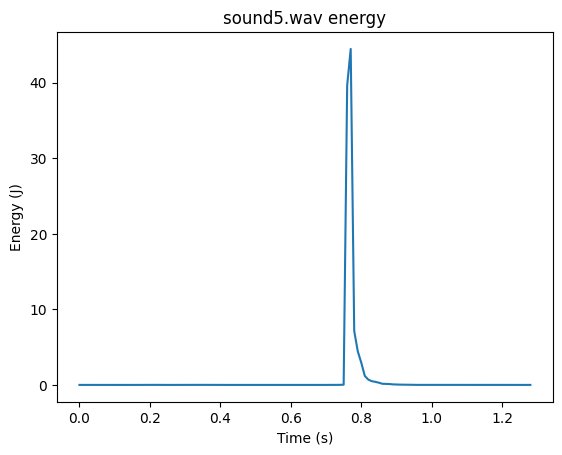

Energy of signal sound5.wav (overlapping frames 50.0%): [0.00233582 0.00114778 0.00269669 ... 0.00046113 0.00053441 0.00130801] J


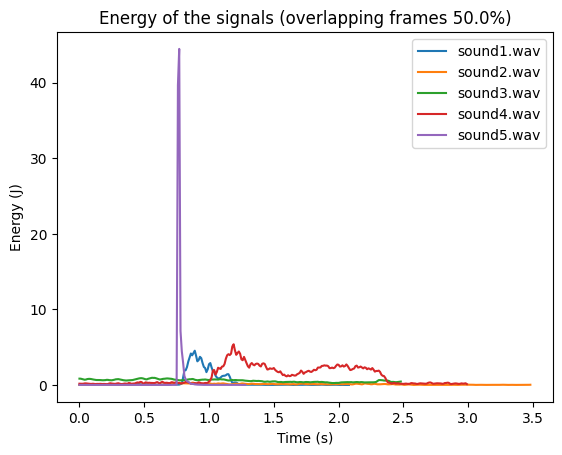

In [5]:
E_frames = []

frame_duration = 0.02  # frame duration in seconds
overlap = 0.5  # overlap percentage
fs = 1 / (frame_duration * overlap)

for signal in signals:
    # get the energy of the signals in overlapping frames of 100ms
    E_frame = (
        overlapping_frames(signal.y, signal.fs, frame_duration, overlap) ** 2
    ).sum(axis=0)
    E_frames.append(E_frame)

    # plot the energy of the signals in continuous time
    plot_continuous(E_frame, fs, f"{signal.file} energy", ylabel="Energy (J)")
    print(
        f"Energy of signal {signal.file} (overlapping frames {overlap * 100}%): {E_frame} J"
    )

for E_frame in E_frames:
    # add the energy of the signal to the final plot with the energy of all the signals
    t = np.arange(len(E_frame)) / fs
    plt.plot(t, E_frame)

# plot the energy of all the signals in continuous time
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title(f"Energy of the signals (overlapping frames {overlap * 100}%)")
plt.legend([signal.file for signal in signals])
plt.show()

## Ejercicio 1.5
Obtenemos el pitch de nuestra voz

/var/folders/bz/10y1qstj0pg7v3tl3lm29hkm0000gn/T/ipykernel_86178/4023001045.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, y = wav.read(os.path.join(AUDIO_DIR, "mi_sonido.wav"))


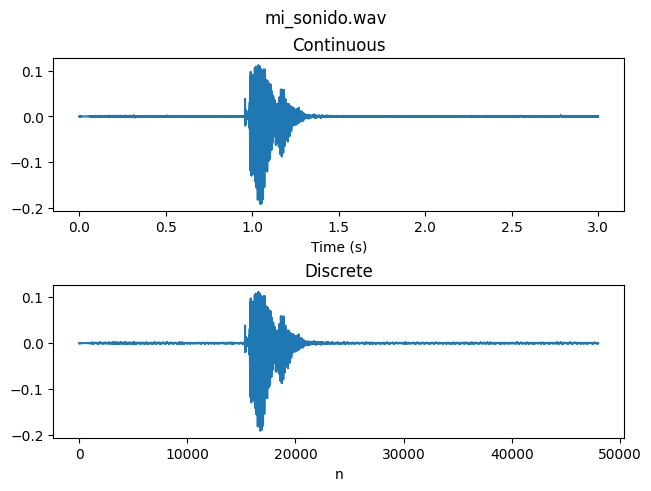

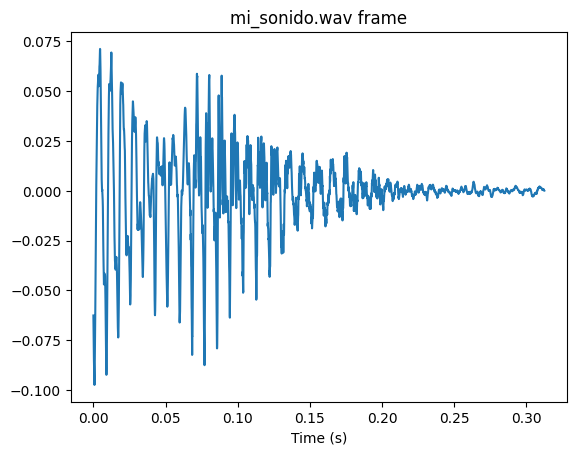

Fundamental frecuecny of signal mi_sonido.wav: 130.66666666666666 hz
Power of signal mi_sonido.wav: 0.00019345559121575207 W
Energy of signal mi_sonido.wav: 9.285868644714355 J


In [6]:
# get the signal and the sampling frequency
fs, y = wav.read(os.path.join(AUDIO_DIR, "mi_sonido.wav"))
signal = Signal(y, fs, "mi_sonido.wav")

# extract a frame from the original signal.
yframe = signal.y[17500:22500]

# plot the signal
plot_continuous_discrete(signal.y, signal.fs, signal.file)
plot_continuous(yframe, signal.fs, f"{signal.file} frame")

# calculate the fundamental frequency of the signal
fundamental_frequency = calculate_fundamental_frequency(signal.y, signal.fs)
print(f"Fundamental frecuecny of signal {signal.file}: {fundamental_frequency} hz")

# calculate the power and energy of the signal
print(f"Power of signal {signal.file}: {(signal.y ** 2).mean()} W")
print(f"Energy of signal {signal.file}: {(signal.y ** 2).sum()} J")